# Importation de bibliothèques

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator


import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime

import tensorflow as tf
import os
from tqdm import tqdm

In [ ]:
# trdata = ImageDataGenerator()
# data_dir='C:/Users/Ab SANOGO/Downloads/Projet s2/Data-20220902T055650Z-001/Data/faces_ilbp_train'
# traindata = trdata.flow_from_directory(directory=data_dir,target_size=(224,224))
# tsdata = ImageDataGenerator()
# test_dir= 'C:/Users/Ab SANOGO/Downloads/Projet s2/Data-20220902T055650Z-001/Data/faces_ilbp_test'
# testdata = tsdata.flow_from_directory(directory=test_dir, target_size=(224,224))

## 1. Chargement des donnnées

In [ ]:
def _get_data(path):
    class_names = os.listdir(path)
    image_paths = []
    labels = []
    for name in class_names:
        directory = os.path.join(path, name)
        #directory = path + "/" + name
        #print(directory)
        class_path = [os.path.join(directory, f) for f in os.listdir(directory)]
        #class_path = [directory + "/" + f for f in os.listdir(directory)]
        image_paths += class_path
        labels.extend([name] * len(class_path))
    return image_paths, labels

In [ ]:
faces_paths, labels = _get_data("/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/Data/faces_ilbp_train")

In [ ]:
def Open_faces_cnn(imgs_paths, labels):
    imgs = []
    labs = []
    for k in tqdm(range(len(imgs_paths))):
        imgs.append(cv2.resize(cv2.imread(imgs_paths[k]), (224,224)))
        labs.append(labels[k])
    return imgs, labs   


### Train

In [ ]:
faces_train, labels_train = Open_faces_cnn(faces_paths, labels)

100%|██████████| 1763/1763 [18:46<00:00,  1.57it/s]


Nombre de faces détectées par ILBPcascade:  1763
Nombre de labels ILBPcascade:  1763


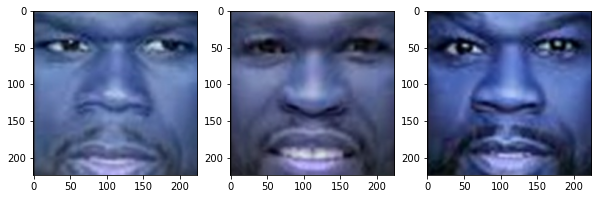

In [ ]:

print('Nombre de faces détectées par ILBPcascade: ', len(faces_train))
print('Nombre de labels ILBPcascade: ', len(labels_train))


i = 30
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(faces_train[i])
plt.subplot(132)
plt.imshow(faces_train[i+1])
plt.subplot(133)
plt.imshow(faces_train[i+2])

In [ ]:
len(np.unique(labels_train))

32

### Test

In [ ]:
faces_paths_test, labels_test = _get_data("/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/Data/faces_ilbp_test")

In [ ]:
faces_test, labels_test = Open_faces_cnn(faces_paths_test, labels_test)

100%|██████████| 630/630 [05:32<00:00,  1.89it/s]


Nombre de faces détectées par ILBPcascade:  630
Nombre de labels ILBPcascade:  630


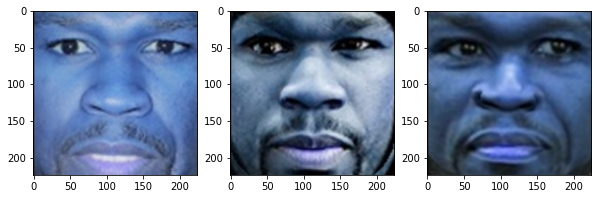

In [ ]:

print('Nombre de faces détectées par ILBPcascade: ', len(faces_test))
print('Nombre de labels ILBPcascade: ', len(labels_test))


i = 0
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(faces_test[i])
plt.subplot(132)
plt.imshow(faces_test[i+1])
plt.subplot(133)
plt.imshow(faces_test[i+2])

In [ ]:
len(np.unique(labels_test))

32

### Encodage des labels

In [ ]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import numpy as np
lb = LabelBinarizer()

### Train

In [ ]:
lb.fit(labels_train)
y_train = lb.transform(labels_train)
y_train.shape

(1763, 32)

### Test

In [ ]:
lb.fit(labels_test)
y_test = lb.transform(labels_test)
y_test.shape

(630, 32)

# 2. Normalisation des données

### Train

In [ ]:
faces_train = np.array(faces_train)/255.0

In [ ]:
faces_train.shape

(1763, 224, 224, 3)

### Test

In [ ]:
faces_test = np.array(faces_test)/255.0

In [ ]:
faces_test.shape

(630, 224, 224, 3)

In [ ]:
faces_test[0]

array([[[0.        , 0.        , 0.01960784],
        [0.        , 0.        , 0.02352941],
        [0.        , 0.        , 0.03137255],
        ...,
        [0.        , 0.        , 0.08235294],
        [0.        , 0.        , 0.08235294],
        [0.        , 0.        , 0.08235294]],

       [[0.        , 0.        , 0.02352941],
        [0.04705882, 0.05490196, 0.08627451],
        [0.12156863, 0.13333333, 0.18039216],
        ...,
        [0.10588235, 0.1372549 , 0.23921569],
        [0.10196078, 0.13333333, 0.23137255],
        [0.09803922, 0.12941176, 0.23137255]],

       [[0.        , 0.        , 0.03137255],
        [0.12156863, 0.13333333, 0.18039216],
        [0.30196078, 0.33333333, 0.4       ],
        ...,
        [0.27058824, 0.34509804, 0.47058824],
        [0.25882353, 0.33333333, 0.45882353],
        [0.25098039, 0.3254902 , 0.45098039]],

       ...,

       [[0.        , 0.        , 0.03921569],
        [0.08235294, 0.09411765, 0.14117647],
        [0.20784314, 0

# 3. Elaboration du model

In [ ]:
import keras
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16
num_classes = len(np.unique(labels_train))
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=True) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
model.add(Dense(100,activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(num_classes, activation='softmax'))



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 100)               100100    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 32)                3232      
                                                                 
 dense_3 (Dense)             (None, 100)               3300      
                                                                 
 dense_4 (Dense)             (None, 100)               1

In [ ]:

from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:

hist = model.fit(faces_train,y_train,
          batch_size=4,
          epochs=100,
         # verbose=1,
          validation_data = (faces_test,y_test))

